In [1]:
%run setup.py

# Read in Kepler sample

In [2]:
stars = pd.read_excel(work_dir+'sample/clumps.xlsx')

# Query light curves and calculate power spectra

In [3]:
from astropy.timeseries import LombScargle

def fourier(x, y, oversampling=1, freqMin=None, freqMax=None, freq=None, return_val="power"):
    """
    Calculate the power spectrum density for a discrete time series.
    https://en.wikipedia.org/wiki/Spectral_density


    Input:
    x: array-like[N,]
        The time array.

    y: array-like[N,]
        The flux array.


    Optional input:
    oversampling: float, default: 1
        The oversampling factor to control the frequency grid.
        The larger the number, the denser the grid.

    freqMin: float, default: frequency resolution

    freqMax: float, default: nyquist frequency


    Output:
    freq: np.array
        The frequency, in unit of [x]^-1.

    psd: np.array
        The power spectrum density, in unit of [y]^2/[x].
        https://en.wikipedia.org/wiki/Spectral_density


    Examples:
    >>> ts = np.load("flux.npy")
    >>> t = ts["time_d"]   # the time in day
    >>> f = ts["flux_mf"]   # the relative flux fluctuated around 1
    >>> f = (f-1)*1e6   # units, from 1 to parts per million (ppm)

    >>> freq, psd = se.psd(t, f, return_val="psd_new")
    >>> freq = freq/(24*3600)*1e6   # c/d to muHz
    >>> psd = psd*(24*3600)*1e-6   # ppm^2/(c/d) to ppm^2/muHz

    """

    if not (return_val in ["psd_old", "periodogram", "power", "amplitude", "psd_new", "window"]):
        raise ValueError("return_val should be one of ['psd_old', 'periodogram', 'power', 'amplitude', 'psd_new', 'window'] ")

    Nx = len(x)
    dx = np.median(x[1:]-x[:-1]) 
    fs = 1.0/dx
    Tobs = dx*len(x)
    fnyq = 0.5*fs
    dfreq = fs/Nx

    if freqMin is None: freqMin = dfreq
    if freqMax is None: freqMax = fnyq

    if freq is None: freq = np.arange(freqMin, freqMax, dfreq/oversampling)
    
    if return_val == "psd_old":
        p = LombScargle(x, y).power(freq, normalization='psd')*dx*4.
    if return_val == "periodogram":
        p = LombScargle(x, y).power(freq, normalization='psd')
    if return_val == "power":
        p = LombScargle(x, y).power(freq, normalization='psd')/Nx*4.
    if return_val == "amplitude":
        p = np.sqrt(LombScargle(x, y).power(freq, normalization='psd')/Nx*4.)
    if return_val == "psd_new":
        nu = 0.5*(freqMin+freqMax)
        freq_window = np.arange(freqMin, freqMax, dfreq/10)
        power_window = LombScargle(x, np.sin(2*np.pi*nu*x)).power(freq_window, normalization="psd")/Nx*4.
        Tobs = 1.0/np.sum(np.median(freq_window[1:]-freq_window[:-1])*power_window)
        p = (LombScargle(x, y).power(freq, normalization='psd')/Nx*4.)*Tobs
    if return_val == "window":
        nu = 0.5*(freqMin+freqMax)
        freq_window = np.arange(freqMin, freqMax, dfreq/10)
        power_window = LombScargle(x, np.sin(2*np.pi*nu*x)).power(freq_window, normalization="psd")/Nx*4.
        freq, p = freq_window-nu, power_window

    return freq, p

def smooth(x, window_len = 11, window = "hanning"):
    # stole from https://scipy.github.io/old-wiki/pages/Cookbook/SignalSmooth
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len < 3:
        return x
    if not window in ["flat", "hanning", "hamming", "bartlett", "blackman", "gaussian"]:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s = x #np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    if window == "flat":
        w = np.ones(window_len,"d")
    elif window == "gaussian":
        w = gaussian(np.arange(-window_len*3, window_len*3,1), 
                    0, window_len, 1./(np.sqrt(2*np.pi)*window_len))
    else:
        w = eval("np."+window+"(window_len)") 
    
    y = np.convolve(w/w.sum(),s,mode="same")
    return y

def smoothWrapper(x, y, windowSize, windowType, samplingInterval=None):
    '''
    Wrapping a sliding-average smooth function.

    Input:
    x: the independent variable of the time series.
    y: the dependent variable of the time series.
    windowSize: the period/width of the sliding window.
    windowType: flat/hanning/hamming/bartlett/blackman/gaussian
    samplingInterval: the time between adjacent sampling points.

    Output:
    yf: the smoothed time series with the exact same points as x.

    '''

    if len(x) != len(y): 
        raise ValueError("x and y must have equal size.")
        
    if samplingInterval is None: samplingInterval = np.median(x[1:-1] - x[0:-2])

    xp = np.arange(np.min(x),np.max(x),samplingInterval)
    yp = np.interp(xp, x, y)
    window_len = int(windowSize/samplingInterval)
    if window_len % 2 == 0:
        window_len = window_len + 1
    ys = smooth(yp, window_len, window = windowType)
    yf = np.interp(x, xp, ys)

    return yf

def medianFilter(x, y, period, yerr=None):
    if yerr==None: iferror=False
    yf = medianSmooth(x, y, period)
    ynew = y/yf #y-yf
    if iferror: yerrnew = yerr/yf

    if iferror:
        return ynew, yerrnew
    else:
        return ynew
    
def medianSmooth(x, y, period):
    binsize = np.median(np.diff(x))
    kernelsize = int(period/binsize)
    if kernelsize%2==0: kernelsize+=1
    from scipy.signal import medfilt
    yf = medfilt(y,kernel_size=kernelsize)
    return yf

def lookup(starname, lc_window=1., psd_window=0.1, oversampling=1.):
    search_result = lk.search_lightcurve(starname, author='Kepler')
    lc_collection = search_result.download_all()
    lc_stitched = lc_collection.stitch()

    # lc_stitched.plot(ax=ax);
    t,f = lc_stitched['time'].value, lc_stitched['flux'].value
    idx = np.isfinite(t) & np.isfinite(f) #& (lc_stitched['quality'].value ==0)
    t,f = t[idx], f[idx]
    fs = medianFilter(t,f,lc_window)
    f = (f-1)*1e6
    fs = (fs-1)*1e6
    freq, psd = fourier(t,fs,return_val='psd_new', oversampling=oversampling)
    freq, psd = freq/(24*3600)*1e6, psd*(24*3600)*1e-6
    psds = smoothWrapper(freq, psd, psd_window, 'bartlett')
    return t,f,fs,freq, psd,psds

In [4]:
stardata = []
kics = [4139914, 5000307, 11502092]
Nstars = len(kics)
for istar in range(Nstars):
    kic = kics[istar]
    star = stars.iloc[np.where(stars['KIC']==kic)[0][0]]
    Dnu = star['Delnu']

    t,f,fs,freq, psd,psds = lookup('KIC {:0.0f}'.format(kic), lc_window=1., psd_window=Dnu/15., oversampling=1.)
    stardata.append([t,f,fs,freq,psd,psds])

# Plot Extended Figure 2 - power spectra

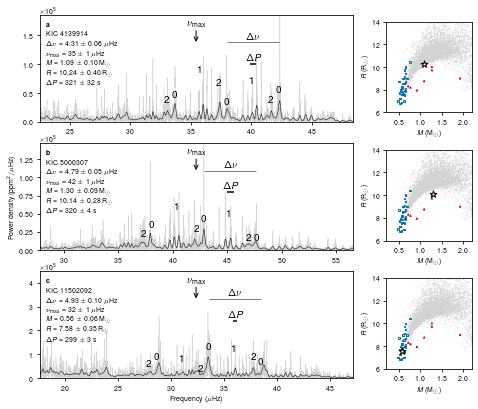

In [18]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from matplotlib.ticker import ScalarFormatter

gridspec_kw = {'left':0.09, 'right':0.92, 'top':0.97, 'bottom':0.08, 'wspace':0.2, 'hspace':0.20}
mosaic = [[0, 0, 0, 'A'],
          [1, 1, 1, 'B'],
          [2, 2, 2, 'C']]
fig, axes = plt.subplot_mosaic(mosaic, gridspec_kw=gridspec_kw, figsize=nature_size('double', ratio=0.8))

# kics = [5000307, 7968120, 11502092]

l0s_start = [38., 42.9, 33.6]
DPi1s = [321., 320.2, 299.1] 
e_DPi1s = [32., 4., 3.] # from vrard+16
Nstars = len(kics)
syns = ['A', 'B', 'C']
colors = ['k', 'k', 'k']

for istar in range(Nstars):
    kic = kics[istar]
    star = stars.iloc[np.where(stars['KIC']==kic)[0][0]]
    if np.isfinite(star['Dnu_freq']):
        Dnu, numax, mass, radius = star['Dnu_freq'], star['numax'], star['mass'], star['radius']
        e_Dnu, e_numax, e_mass, e_radius = star['e_Dnu_freq'], star['e_numax'], star['e_mass'], star['e_radius']
    else:
        Dnu, numax, mass, radius = star['Delnu'], star['numax'], star['ClcorM'], star['ClcorR']
        e_Dnu, e_numax, e_mass, e_radius = star['e_Delnu'], star['e_numax'], star['e_ClcorM'], star['e_ClcorR']
        
    DPi1 = DPi1s[istar]
    e_DPi1 = e_DPi1s[istar]
    
    t,f,fs,freq, psd,psds = stardata[istar]
    
    axes[istar].plot(freq, psd, color='lightgray', linewidth=0.5, rasterized=True)
    axes[istar].plot(freq, psds, color=colors[istar], linestyle='-', linewidth=0.5)
    
    axes[istar].axis([numax-3*Dnu, numax+3*Dnu,0., 5.0*np.max(psds[(freq>(numax-4*Dnu)) & (freq<(numax+4*Dnu))])]) #20,75
    axes[istar].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    
    texts = ['KIC {:0.0f}'.format(star['KIC']),
             '$\\Delta\\nu$ = {:0.2f} $\\pm$ {:0.2f} $\\mu$Hz'.format(Dnu, e_Dnu),
             '$\\nu_{\\rm max}$ = '+'{:0.0f} $\\pm$ {:0.0f} $\\mu$Hz'.format(numax, e_numax),
             '$M$ = {:0.2f} $\\pm$ {:0.2f}'.format(mass, e_mass)+' M$_{\\odot}$',
             '$R$ = {:0.2f} $\\pm$ {:0.2f}'.format(radius, e_radius)+' R$_{\\odot}$',
             '$\\Delta P$ = {:0.0f} $\\pm$ {:0.0f} s'.format(DPi1, e_DPi1)]
    for itext, text in enumerate(texts):
        if itext==6:
            axes[istar].text(0.02, 0.81-itext*0.09, text, color=red, transform=axes[istar].transAxes, fontsize=fontsize)
        else:
            axes[istar].text(0.02, 0.81-itext*0.09, text, transform=axes[istar].transAxes, fontsize=fontsize)
        
    # mass radius diagram
    axins = inset_axes(axes[syns[istar]], bbox_to_anchor=(0.15, 0.1, 0.93, 0.85), # x,y,width,height 0.75
                       bbox_transform=axes[syns[istar]].transAxes, height="100%", width="100%", loc=2) #
    
    axes[syns[istar]].get_xaxis().set_visible(False)
    axes[syns[istar]].get_yaxis().set_visible(False)
    axes[syns[istar]].spines['right'].set_visible(False)
    axes[syns[istar]].spines['left'].set_visible(False)
    axes[syns[istar]].spines['top'].set_visible(False)
    axes[syns[istar]].spines['bottom'].set_visible(False)
    
    
    # Select all very-low-mass HeB stars
    lidx = (stars['Phase']==2) & (stars['ifclump']==1) & (np.abs(stars['dist_mass_sig'])>1)
    # Select all under-luminous HeB stars
    uidx = (stars['Phase']==2) & (stars['ifclump']==2) & (np.abs(stars['dist_nike_sig'])>1)
    # Select other ordinary/regular HeB stars
    oidx = (stars['Phase']==2) & (stars['ifclump']!=-1) & (~lidx) & (~uidx)
    heb = lidx | uidx | oidx

    scatterstyle = {'marker':'.', 'color':'lightgray', 's':0.2, 'zorder':-100}
    sscatterstyle = {'marker':'^', 'edgecolor':red, 'facecolor':'none', 's':2, 'zorder':2}
    lscatterstyle = {'marker':'s', 'edgecolor':blue, 'facecolor':'none', 's':2, 'zorder':3}
    cscatterstyle = {'marker':'s', 'edgecolor':'purple', 'facecolor':'none', 's':2, 'zorder':4}
    nscatterstyle = {'marker':'*', 'edgecolor':'k', 'facecolor':yellow, 's':50, 'zorder':100}

    axins.scatter(stars.loc[oidx,'ClcorM'], stars.loc[oidx,'ClcorR'], rasterized=True, **scatterstyle)
    axins.scatter(stars.loc[uidx,'ClcorM'], stars.loc[uidx,'ClcorR'], rasterized=True, **sscatterstyle)
    axins.scatter(stars.loc[lidx,'ClcorM'], stars.loc[lidx,'ClcorR'], rasterized=True, **lscatterstyle)
    axins.scatter(mass, radius, **nscatterstyle)
    

    axins.axis([0.2, 2.2, 6., 14.])
    axins.set_xlabel('$M$ (M$_{\\odot}$)')
    axins.set_ylabel('$R$ (R$_{\\odot}$)')
    
    
    # mark l-degrees
    l0s = np.arange(-1,2,1)*star['Delnu'] + l0s_start[istar]
    l2s = l0s - Dnu*0.15
    l1s = l0s[:-1] + Dnu*0.5
    
    for fc in l0s:
        yfc = np.max(psds[(freq>(fc-0.03*Dnu)) & (freq < (fc+0.03*Dnu))])
        axes[istar].text(fc, yfc*1.5, '0', ha='center', va='center')
        
    for fc in l1s:
        yfc = np.max(psds[(freq>(fc-0.06*Dnu)) & (freq < (fc+0.06*Dnu))])
        axes[istar].text(fc, yfc*3.0, '1', ha='center', va='center')
        
    for fc in l2s:
        yfc = np.max(psds[(freq>(fc-0.03*Dnu)) & (freq < (fc+0.03*Dnu))])
        axes[istar].text(fc, yfc*2.0, '2', ha='center', va='center')
        
    arrowprops = {'arrowstyle':'->'}
    # mark numax
    ynumax = 0.91*axes[istar].get_ylim()[1] 
    axes[istar].annotate('$\\nu_{\\rm max}$', (numax, ynumax*0.80), (numax, ynumax), arrowprops=arrowprops, ha='center')
 
    # mark Dnu
    fDnu = np.mean(l0s[1:])
    yDnu = 0.80*axes[istar].get_ylim()[1] 
    axes[istar].text(fDnu, yDnu, '$\\Delta\\nu$', ha='center', va='center', zorder=100)
    axes[istar].errorbar(fDnu, yDnu*0.93, xerr=0.5*Dnu, capsize=0, linewidth=0.5, color='k', ecolor='k', zorder=100)
    
    # mark DPi1
    fdp = np.mean(l0s[1:])
    ydp = 0.60*axes[istar].get_ylim()[1] 
    axes[istar].text(fdp, ydp, '$\\Delta P$', ha='center', va='center')
    axes[istar].errorbar(fDnu, ydp*0.9, xerr=0.5*DPi1*fdp**2.0*1e-6, capsize=0, linewidth=1.5, color='k', ecolor='k', zorder=100)

axes[2].set_xlabel('Frequency ($\\mu$Hz)')
axes[1].set_ylabel('Power density (ppm$^2/\\mu$Hz)')
labels = ['{\\textbf{a}}', '{\\textbf{b}}', '{\\textbf{c}}', '{\\textbf{d}}']
for iax in range(3):
    axes[iax].text(0.02, 0.9, labels[iax], transform=axes[iax].transAxes, fontsize=fontsize)

plt.savefig(overleaf_path+'Fig_extended_2_power_spectra.pdf')

# Plot Extended Figure 3 - period echelle

In [6]:
def echelle(x, y, period, fmin=None, fmax=None, echelletype="single", offset=0.0):
    '''
    Generate a z-map for echelle plotting.

    Input:

    x: array-like[N,]
    y: array-like[N,]
    period: the large separation,
    fmin: the lower boundary
    fmax: the upper boundary
    echelletype: single/replicated
    offset: the horizontal shift

    Output:

    x, y: 
        two 1-d arrays.
    z: 
        a 2-d array.

    Exemplary call:

    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(6,8))
    ax1 = fig.add_subplot(111)
    echx, echy, echz = echelle(tfreq,tpowers_o,dnu,numax-9.0*dnu,numax+9.0*dnu,echelletype="single",offset=offset)
    levels = np.linspace(np.min(echz),np.max(echz),500)
    ax1.contourf(echx,echy,echz,cmap="gray_r",levels=levels)
    ax1.axis([np.min(echx),np.max(echx),np.min(echy),np.max(echy)])
    if offset > 0.0:
        ax1.set_xlabel("(Frequency - "+str("{0:.2f}").format(offset)+ ") mod "+str("{0:.2f}").format(dnu) + " ($\mu$Hz)")
    if offset < 0.0:
        ax1.set_xlabel("(Frequency + "+str("{0:.2f}").format(np.abs(offset))+ ") mod "+str("{0:.2f}").format(dnu) + " ($\mu$Hz)")
    if offset == 0.0:
        ax1.set_xlabel("Frequency mod "+str("{0:.2f}").format(dnu) + " ($\mu$Hz)")
    plt.savefig("echelle.png")

    '''

    if not echelletype in ["single", "replicated"]:
        raise ValueError("echelletype is on of 'single', 'replicated'.")

    if len(x) != len(y): 
        raise ValueError("x and y must have equal size.")    

    if fmin is None: fmin=0.
    if fmax is None: fmax=np.nanmax(x)

    fmin = fmin - offset
    fmax = fmax - offset
    x = x - offset

    if fmin <= 0.0:
        fmin = 0.0
    else:
        fmin = fmin - (fmin % period)

    # first interpolate
    samplinginterval = np.median(x[1:-1] - x[0:-2]) * 0.1
    xp = np.arange(fmin,fmax+period,samplinginterval)
    yp = np.interp(xp, x, y)

    n_stack = int((fmax-fmin)/period)
    n_element = int(period/samplinginterval)
    #print(n_stack,n_element,len())

    morerow = 2
    arr = np.arange(1,n_stack) * period # + period/2.0
    arr2 = np.array([arr,arr])
    yn = np.reshape(arr2,len(arr)*2,order="F")
    yn = np.insert(yn,0,0.0)
    yn = np.append(yn,n_stack*period) + fmin #+ offset

    if echelletype == "single":
        xn = np.arange(1,n_element+1)/n_element * period
        z = np.zeros([n_stack*morerow,n_element])
        for i in range(n_stack):
            for j in range(i*morerow,(i+1)*morerow):
                z[j,:] = yp[n_element*(i):n_element*(i+1)]
    if echelletype == "replicated":
        xn = np.arange(1,2*n_element+1)/n_element * period
        z = np.zeros([n_stack*morerow,2*n_element])
        for i in range(n_stack):
            for j in range(i*morerow,(i+1)*morerow):
                z[j,:] = np.concatenate([yp[n_element*(i):n_element*(i+1)],yp[n_element*(i+1):n_element*(i+2)]])

    return xn, yn, z

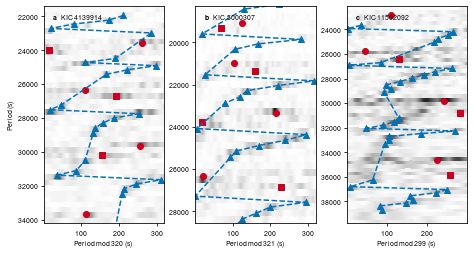

In [10]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from matplotlib.ticker import ScalarFormatter
import json

gridspec_kw = {'left':0.09, 'right':0.92, 'top':0.97, 'bottom':0.12, 'wspace':0.26, 'hspace':0.20}
fig, axes = plt.subplots(nrows=1, ncols=3, gridspec_kw=gridspec_kw, figsize=nature_size('double', ratio=0.5))

Nstars = 3

DPi1s = [319.7, 321., 299.1] #299.1
for istar in range(Nstars):
    kic = kics[istar]
    star = stars.iloc[np.where(stars['KIC']==kic)[0][0]]
    Dnu, numax, mass, radius = star['Delnu'], star['numax'], star['ClcorM'], star['ClcorR']
    e_Dnu, e_numax, e_mass, e_radius = star['e_Delnu'], star['e_numax'], star['e_ClcorM'], star['e_ClcorR']
    
    DPi1 = DPi1s[istar]
#     DPi1 = star['DPi1']
    
    t,f,fs,freq, psd,psds = stardata[istar]
    psds_small = smoothWrapper(freq, psd, Dnu/100., 'bartlett')

    ll, ul = 1.5, 2.5
    fmin = numax-ll*Dnu
    fmax = numax+ul*Dnu
    
    equal_period = np.arange(1/fmax*1e6, 1/fmin*1e6, np.min(np.abs(np.diff(1e6*1/freq[(freq>fmin) & (freq<fmax)]))))
    equal_period_psds = np.interp(equal_period, 1e6/freq[::-1], psds_small[::-1])
    
    echx, echy, echz = echelle(equal_period, equal_period_psds, DPi1, 1/(numax+ul*Dnu)*1e6, 1/(numax-ll*Dnu)*1e6, echelletype="single", offset=0)

    levels = np.linspace(np.min(echz),np.max(echz),500)
    cs=axes[istar].contourf(echx,echy,echz,cmap="gray_r",levels=levels)
    
    for c in cs.collections:
        c.set_rasterized(True)
    
    axes[istar].axis([np.min(echx),np.max(echx),np.max(echy),np.min(echy)])
    axes[istar].set_xlabel('Period mod ${:0.0f}$ (s)'.format(DPi1))
    
    
    with open(work_dir+'sample/three_stars_frequencies/labelled_points_{:0.0f}.json'.format(istar+1)) as f:
        freq_data = json.load(f)
    markers=['o', '^', 's']
    colors=[red, blue, red]
    for l in range(0,3):
        fs = np.array(freq_data['{:0.0f}'.format(l)])
        ps = np.sort(1e6/fs)
        if l==1:
            axes[istar].scatter(ps%DPi1, ps, marker=markers[l], color=colors[l])
            axes[istar].plot(ps%DPi1, ps, linestyle='--', color=colors[l])
        else:
            axes[istar].scatter(ps%DPi1, ps, marker=markers[l], color=colors[l])
        
    

axes[0].set_ylabel('Period (s)')
labels = ['{\\textbf{a}}', '{\\textbf{b}}', '{\\textbf{c}}', '{\\textbf{d}}']
for iax in range(3):
    axes[iax].text(0.08, 0.94, labels[iax]+' \\  KIC {:0.0f}'.format(kics[iax]), transform=axes[iax].transAxes, fontsize=fontsize)

plt.savefig(overleaf_path+'Fig_extended_3_period_echelles.pdf')